[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pol-is/notebooks/blob/master/020-PCA.ipynb)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import altair as alt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
import umap

import igraph as ig
import leidenalg

from sklearn.decomposition import PCA

In [7]:
## Set up plots
plt.figure(figsize=(500, 500))
sns.set_context('poster')
sns.set_style('white')
sns.set(font_scale=.7)
sns.set_color_codes()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

<Figure size 50000x50000 with 0 Axes>

### Import raw data && clean up

In [8]:
df = pd.read_csv('../../data/sji-landbank/participants-votes.csv',index_col='participant')
df_comments = pd.read_csv('../../data/sji-landbank/comments.csv',index_col='comment-id')

In [9]:
df_comments.index = df_comments.index.astype(str)

In [10]:
metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

In [11]:
# remove statements (columns) which were moderated out
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

In [12]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`

## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold=7):
    
    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return df[valid]
    
df = select_rows(df)

In [13]:
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)  #<---in paper: column mean
vals = vals.sort_values("participant")
vals_all_in = vals[statements_all_in]

# Overall stats

How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [14]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (357, 299)
Dimensions of matrix: (357, 294)
Total number of possible votes: 104958
Total number of agrees: 17237
Total number of disagrees: 9736
Total without vote: 77985
Percent sparse:  0.7430114903104099 %


### Full participants * comments matrix

Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived. 

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation. 

<Axes: ylabel='participant'>

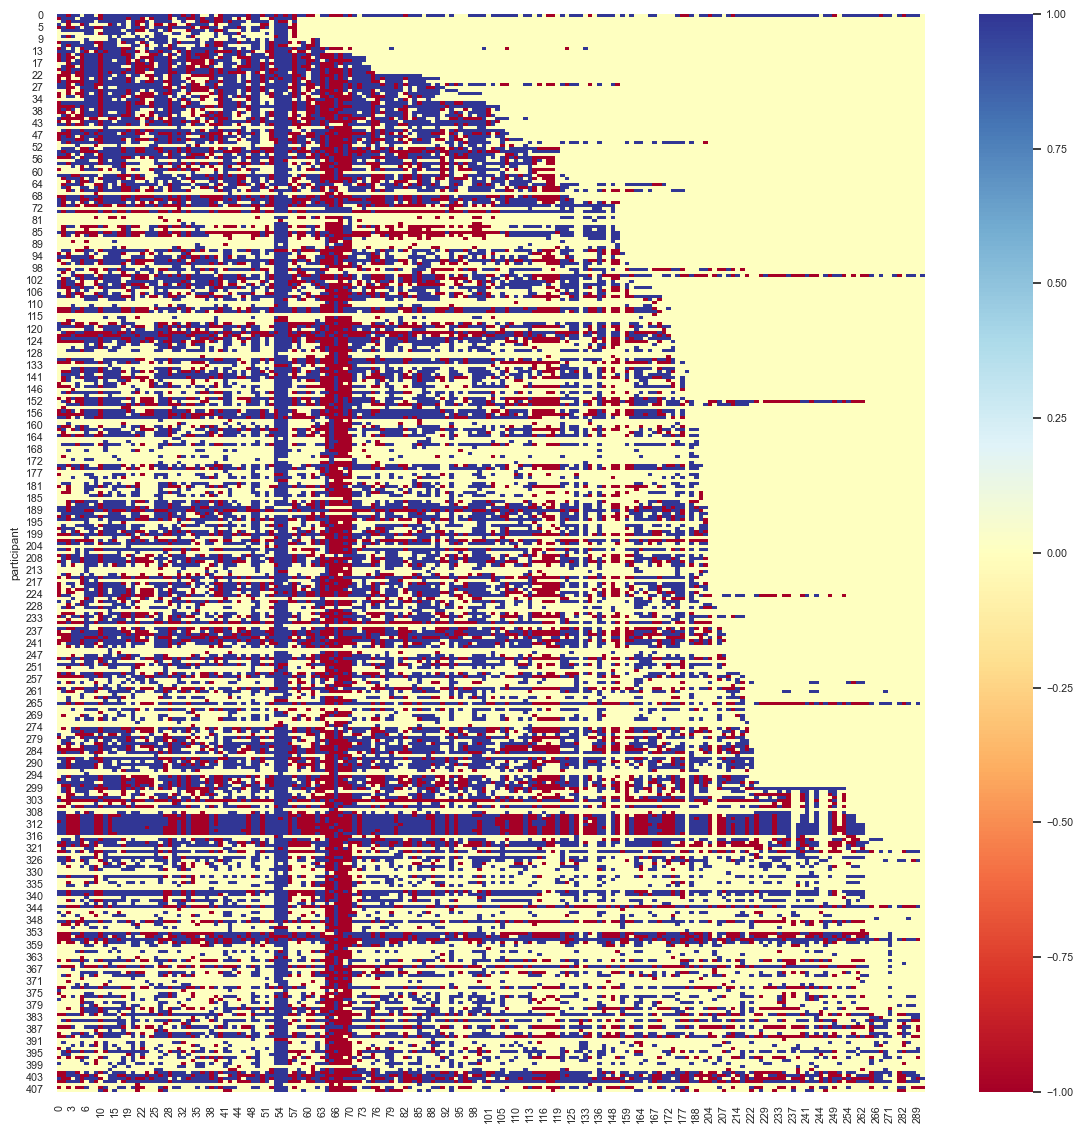

In [15]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax)

In [16]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants 
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip 
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

In [17]:
def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    print('Colorcode is based on how voted not clustering!')
    plt.show()

# Is the space explained by how much people vote?

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial. 
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:
* polis eliminates participants who don't vote at least 7 times from the analysis
* polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

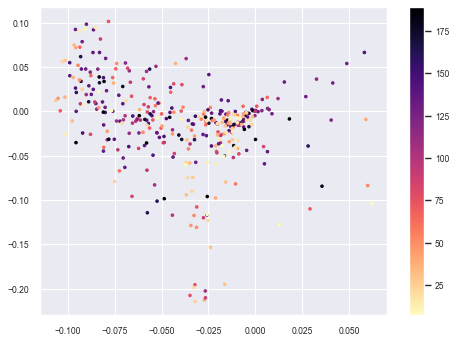

In [18]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0], 
    y=coords[:,1], 
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()

# Opinion groups

To form opinion groups, we take the PCA coordinates and perform K-means clustering with K=100. 
These fine-graine cluster serve as the basis for a more coarse-grained clustering, also using K-means. 
<font color='red'>
*In fact, we take the 100 centers (obtained from the first K-means clustering), and run additional K-means clustering for K ranging between 2 and 5.*
</font>
The K for which the silhoutte coefficient (a measure of withing-cluster similarity vs. between-cluster dissimilarity) is optimal is chosen for the opinion groups.

In [19]:
#given a dataframe, returns the found lables/clusters and the corresponding centers
def polis_kmeans_(dataframe, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dataframe)
    
    return kmeans.labels_, kmeans.cluster_centers_

In [20]:
def plot_embedding_with_clusters(embedding_,labels_):
    print("Plotting PCA embeddings with K-means, K="+str(np.max(labels_)+1))
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding_[:,0],
        y=embedding_[:,1],
        c=labels_,
        cmap="tab20",
        s=5
    )
    #ax.set_title("", fontsize=14)
    

Explained variance: [0.27143327 0.08438013]
Plotting PCA embeddings with K-means, K=100
Optimal clusters for K= 2
Plotting PCA embeddings with K-means, K=2


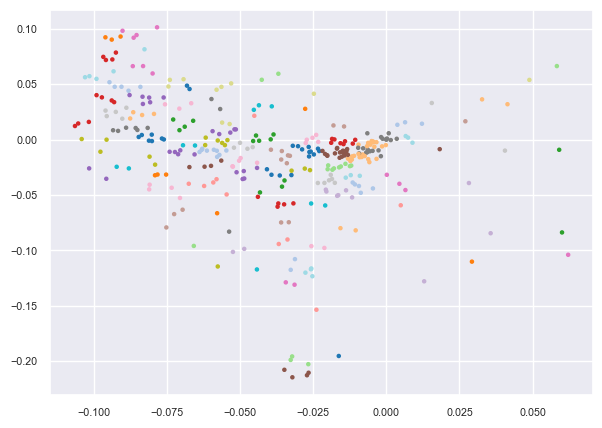

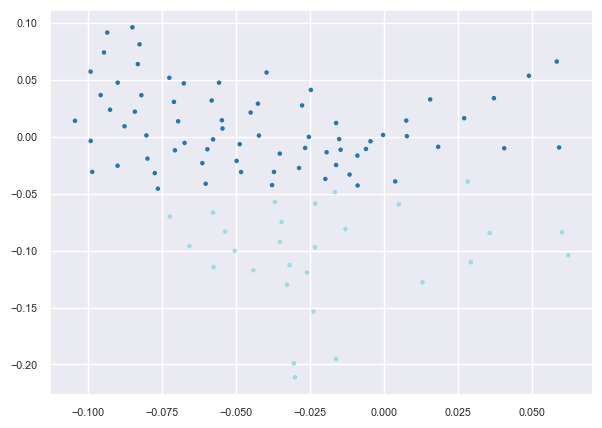

In [21]:
# Step 1 - get PCA clusters 
embedding, explained_variance = polis_pca(vals_all_in, 2)  
print("Explained variance:", explained_variance)

# Step 2 - K-means with K=100
clusters_100, centers = polis_kmeans_(embedding,n_clusters=100)
plot_embedding_with_clusters(embedding, clusters_100)

# Step 3 - find optimal K
from sklearn.metrics import silhouette_score 
silhoutte_star = -np.inf
for K in range(2,6):
    clusters_K, _ = polis_kmeans_(centers,n_clusters=K)
    silhouette_K = silhouette_score(centers, clusters_K)
    if silhouette_K >= silhoutte_star:
        K_star = K
        silhoutte_star = silhouette_K
        clusters_K_star = clusters_K
print('Optimal clusters for K=',str(K_star))
plot_embedding_with_clusters(centers,clusters_K_star)
 
# Step 4 - assign each voter to "optimal" cluster
clusters_star = np.zeros(len(clusters_100))
for k in range(100):#
    #find all indices with clusters k and assign them new star label
    clusters_star[np.where(clusters_100==k)]  = clusters_K_star[k]
    

# Comment Statistics

We analyze comments for how strongly they represent each opinion group.
For that, the representative metric R_v(g,c) is calculated for all groups g, comments c, and possible votes v.
This metric estimates how much more likely participants in group g are vote v on said comment c than those outside group g.

*Definition of R_v(g,c):*
Let N_v(g,c) be the number of participants in group g who cast vote v on comment c, and let N(g,c)   be the total number of votes for comment c within group g (i.e. <font color='red'> N_{+1}(g,c)+  N_{-1}(g,c) <font> )

Defifne P_v(g,c)=(1+N_v(g,v))/(2+N(g,c)) which estimates the probability that a given person in group g votes v on comment c. Then

R_v(g,c) = P_v(g,c)/ P_v(g_not,c)

where g_not denotes the complement of g, thus all participants not in g.

In [22]:
#Step 1: Calculate N_v(g,c), N(g,c), and P_v(g,c)
N_groups, N_comments = clusters_K_star.max()+1, len(statements_all_in)
N_v_g_c = np.zeros([3,N_groups,N_comments]) #create N matrix 
P_v_g_c = np.zeros([3,N_groups,N_comments])
N_g_c = np.zeros([N_groups,N_comments])
v_values = [-1,0,1]

for g in range(N_groups): 
    idx_g = np.where(clusters_star == g)[0] #get indices of cluster g; caution_ idx != participant id
    for c in range(N_comments):
        comment = statements_all_in[c] #comment id
        df_c = vals_all_in[str(comment)].iloc[idx_g] #data frame: [participants of group g,comment c], 
        for v in range(3):
            v_value = v_values[v]
            N_v_g_c[v,g,c] = (df_c == v_value).sum() #counts all v_value votes in data frame df_c
        N_g_c[g,c] = N_v_g_c[0,g,c] + N_v_g_c[2,g,c] #total votes corresponds to votes with +1 or -1  
        
        for v in range(3):
            P_v_g_c[v,g,c] = (1 + N_v_g_c[v,g,c]) / (2 + N_g_c[g,c])
        
#Step2: calculate R_v(g,c)                           
R_v_g_c = np.zeros([3,N_groups,N_comments])
for g in range(N_groups): 
    for c in range(N_comments):
        for v in range(3):
           R_v_g_c[v,g,c] = P_v_g_c[v,g,c] / np.delete(P_v_g_c[v,:,c],g,0).sum()  # np.delete neglects all entries with group g                                           
                                                   


# Comment Selection criterion

Given R_v(g,c), how to decide weather comment c is representative for group g?

Remember: R_v(g,c)=2 means that comment c is 2 times more likely to be voted v in group g compared to all the other groups. 
However, this does not tell us how significant this difference is (a very small likelihood multiplied by 2 is still a very small likelihood).

<font color='red'> 
As a measure of significance, we calculate the Fisher exact test. This quantity can be regarded as a measure of correlation between two random variables. In fact, it tests how significantly the obtained sample (in this case votes v of comment c in group g) is different from the 0 hypothesis (in this case, that votes v are drawn from a hypergeometric distribution with parameters given by including all groups on comment c). 
<font>

We weight this significance measure with R_v(g,c).

In [23]:
import scipy.stats as stats
from scipy.stats import hypergeom

v_values = [-1,0,1]
p_values = np.zeros([N_groups,N_comments,3])
for g in range(N_groups): 
    idx_g = np.where(clusters_star == g)[0] #get indices of cluster g; caution_ idx != participant id
    idx_g_not = np.where(clusters_star != g)[0] #get indices of rest
    for c in range(N_comments):
        comment = statements_all_in[c] #comment id
        
        for v in range(3):
            v_value = v_values[v]
            N_v = (vals_all_in[str(comment)] == v_value).sum()    #totol number of v votes in comment c
            N_rest = (vals_all_in[str(comment)]).count() - N_v    #total number of votes =  number of participants
            
            df_c = vals_all_in[str(comment)].iloc[idx_g]  #get data frame of group g for comment c
            N_v_in_g = (df_c == v_value).sum()
            N_g = (df_c).count()   
            
            [M, n, N] = [N_rest+N_v, N_v, N_g]  #hypergeometric distribution parameters https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
            x = range(N_v_in_g-1 ,N_g+1)
            prb = hypergeom.pmf(x, M, n, N).sum() #calculates P(X>=N_v_in_g), i.e. p-value. 
            p_values[g,c,v] = prb * R_v_g_c[v,g,c]

In [24]:
## Lets print the most significant comments for each group!
for g in range(N_groups): 
    idx_ = np.argsort(p_values[g,:,0]) #take only the significant comments
    print('----------------------------------')
    print('5 significant comments for group ',g)
    print('----------------------------------')
    for i in range(5):
        print(' ')
        print(df_comments['comment-body'][idx_[i]])
        print(' ')
        
        #How to embed comments into plot?
        #idx_[i]
        #participant_comment = np.zeros([1,vals_all_in.shape[0]])
        #participant_comment[0,idx_[i]] = 1
        #latent_comment = pca_object.transform(participant_comment)
        

----------------------------------
5 significant comments for group  0
----------------------------------
 
Oprah, Bill Gates and Inslee should be forced to donate their land!
 
 
Land Bank is not effectively managing existing properties.
 
 
More people and pets are using preserves. Dog presence can negatively impact wildlife.  Can more preserves be restricted from dog access?
 
 
Land Bank leaders would be wise to broaden outreach ahead of next vote, expanding their pool of support and allies.
 
 
If I were fortunate enough to own property next to a Land Bank property, I would be overjoyed at having a public park as my neighbor.
 
----------------------------------
5 significant comments for group  1
----------------------------------
 
The Land Bank lets those of us who can't own huge parcels of land enjoy the beauty of our home
 
 
The Land bank should operate operate in accordance to Washington State land use laws.
 
 
Thoughtfully structured access to Land Bank lands is compatibl

/var/folders/m8/cq4r80r550j7nm4md15gp8bm0000gp/T/ipykernel_77718/2527301118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_comments['comment-body'][idx_[i]])


In [25]:
## lets also include the 5 most significant comments into the PCA embeddings
## for that, treat a comment as a artificial participant who only voted on the respective comment 
## and use the already calculated PCA loadings to project to the 2d plane

#plot_embedding_with_clusters(centers,clusters_K_star)

#pca_object = PCA(n_components=2) ## pca is apparently different, it wants 
#pca_object = pca_object.fit(vals_all_in.T)